In [6]:
import os #For directory and file operations
import numpy as np # For numberical operations and handling image arrays
import random #For generating random values for augmentation
from PIL import Image, ImageEnhance #For image processing and enhancement
from tensorflow.keras.utils import load_img, img_to_array # For loading images
from tensorflow.keras.models import Sequential #For building the model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense #For model layers
from tensorflow.keras.optimizers import Adam # For optimizer
from tensorflow.keras.applications import VGG16 # For using VGG16 model from sklearn.utils import shuffle # For shuffling the data
from sklearn.utils import shuffle #For shuffling the data

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score



In [7]:
# Directories for training and testing data
train_dir = '../archive/Training'
test_dir = '../archive/Testing'

# load and shuffle the train data
train_paths = []
train_labels = []

for label in os.listdir(train_dir):
  for image in os.listdir(os.path.join(train_dir, label)):
    train_paths.append(os.path.join(train_dir, label, image))
    train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

# Load and shuffle test data
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
  for image in os.listdir(os.path.join(test_dir, label)):
    test_paths.append(os.path.join(test_dir, label, image))
    test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

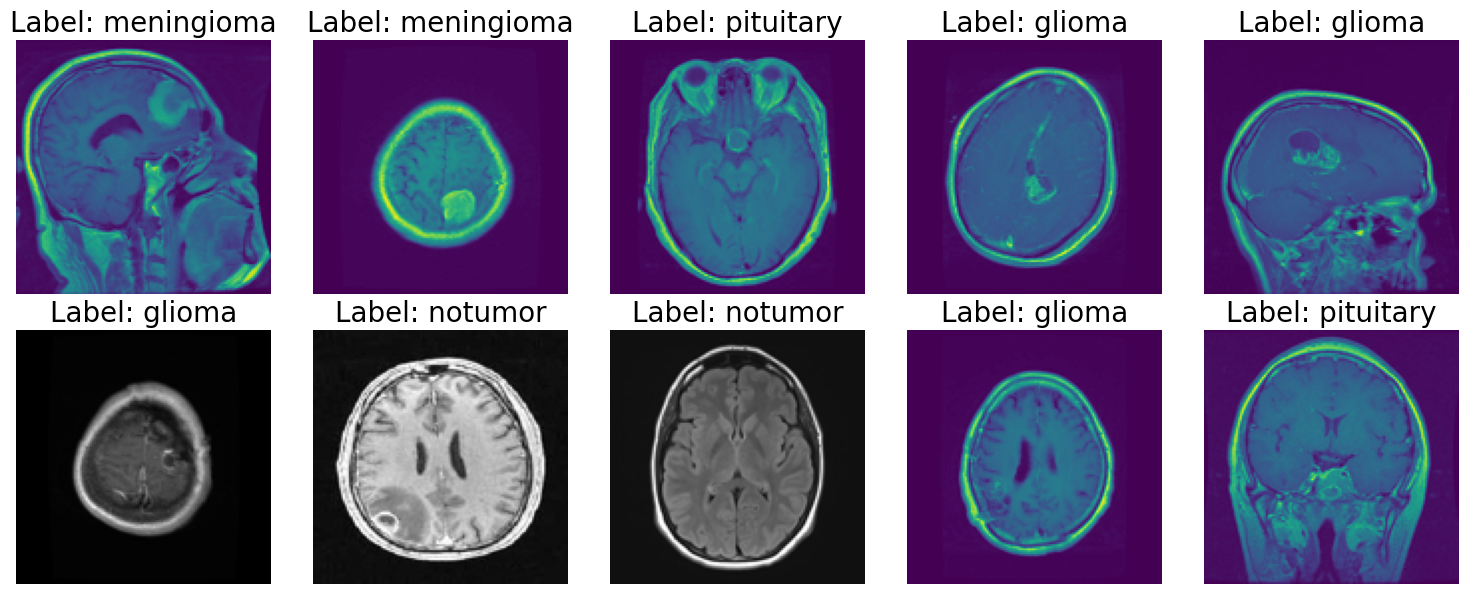

In [16]:
#DATA VISUALIZATION

import random
import matplotlib.pyplot as plt

#Select random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)

# Create a figure to display images in 2 rows
fig, axes = plt.subplots(2,5, figsize=(15,6))
axes = axes.ravel()

#Loop through the random indices and display images
for i,idx in enumerate(random_indices):
  img_path = train_paths[idx]
  img = Image.open(img_path)
  img = img.resize((128, 128))

  #Display images
  axes[i].imshow(img)
  axes[i].axis("off")
  axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=20)


plt.tight_layout()
plt.show()


In [17]:
# IMAGE PREPROCESSING 

def augment_image(image):
    # Convert to array first
    image = img_to_array(image)
    # Convert to PIL Image for enhancement
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    # Convert back to array and normalize
    image = np.array(image)/255.0
    return image

def open_images(paths):
    images = []
    for path in paths:
        img = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        img = augment_image(img)
        images.append(img)
    return np.array(images)

# Encode labels (Convert label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)
    # Encode the actual provided labels, not the directory names
    encoded = [unique_labels.index(label) for label in labels]
    return encoded

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    # Encode all labels once at the start
    encoded_labels = encode_label(labels)
    
    for _ in range(epochs):
        # Create indices for shuffling
        indices = np.arange(len(paths))
        np.random.shuffle(indices)
        
        for i in range(0, len(paths), batch_size):
            batch_indices = indices[i:i+batch_size]
            batch_paths = [paths[idx] for idx in batch_indices]
            batch_images = open_images(batch_paths)
            batch_labels = [encoded_labels[idx] for idx in batch_indices]
            yield batch_images, np.array(batch_labels)

In [18]:
# MODEL ARCHITECTURE 

IMAGE_SIZE = 128
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

#Freeze all layers of the VGG16 base model
for layer in base_model.layers:
  layer.trainable = False

# Set only the lase few layers
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

#Build Model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3))) #Input layer
model.add(base_model) #VGG16 model
model.add(Flatten()) #Flatten layer
model.add(Dropout(0.3)) # Dropout layer

model.add(Dense(128, activation='relu')) # Dense layer
model.add(Dropout(0.2)) # Dropout layer

model.add(Dense(len(os.listdir(train_dir)), activation='softmax')) # Output layer


# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])


# Parameters
batch_size = 20
steps = int(len(train_paths)/ batch_size)
epochs = 5

# Train model
history = model.fit(
  datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs), 
  epochs=epochs, steps_per_epoch=steps
)


Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 312s 1s/step - loss: 0.6702 - sparse_categorical_accuracy: 0.7363
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 252s 884ms/step - loss: 0.2439 - sparse_categorical_accuracy: 0.9082
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 249s 873ms/step - loss: 0.1642 - sparse_categorical_accuracy: 0.9367
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 249s 873ms/step - loss: 0.1042 - sparse_categorical_accuracy: 0.9600
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 248s 870ms/step - loss: 0.0786 - sparse_categorical_accuracy: 0.9716


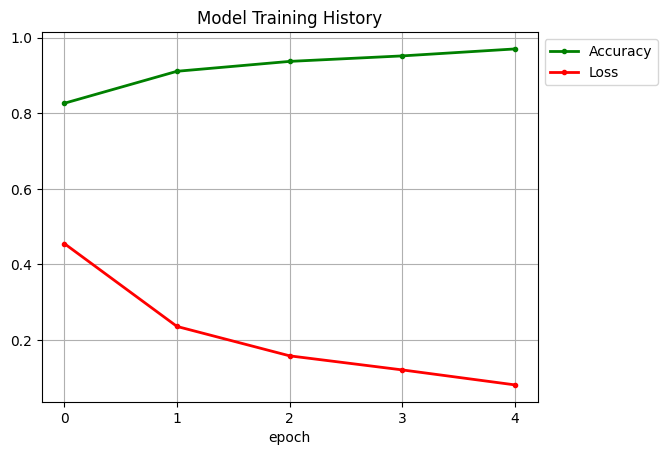

In [21]:
plt.Figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
import numpy as np

test_images = open_images(test_paths)
test_labels_encoded = encode_label(test_labels)

test_predictions = model.predict(test_images)

print("Classification Report: ")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

41/41 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step
Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.90      0.92       300
           1       0.88      0.94      0.91       306
           2       0.98      0.99      0.99       405
           3       0.97      0.95      0.96       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311



Confusion Matrix: 
[[270  28   0   2]
 [  7 288   5   6]
 [  5   0 400   0]
 [  2  10   2 286]]


Text(70.72222222222221, 0.5, 'True')

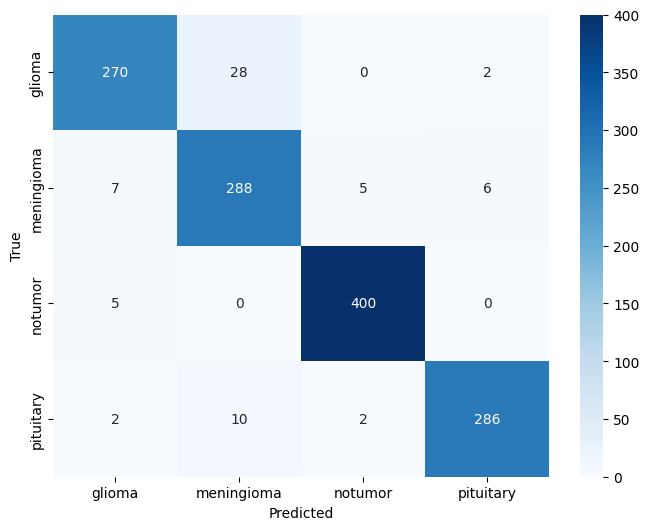

In [27]:
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis = 1))
print("Confusion Matrix: ")
print(conf_matrix)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.xlabel('Predicted')
plt.ylabel("True")

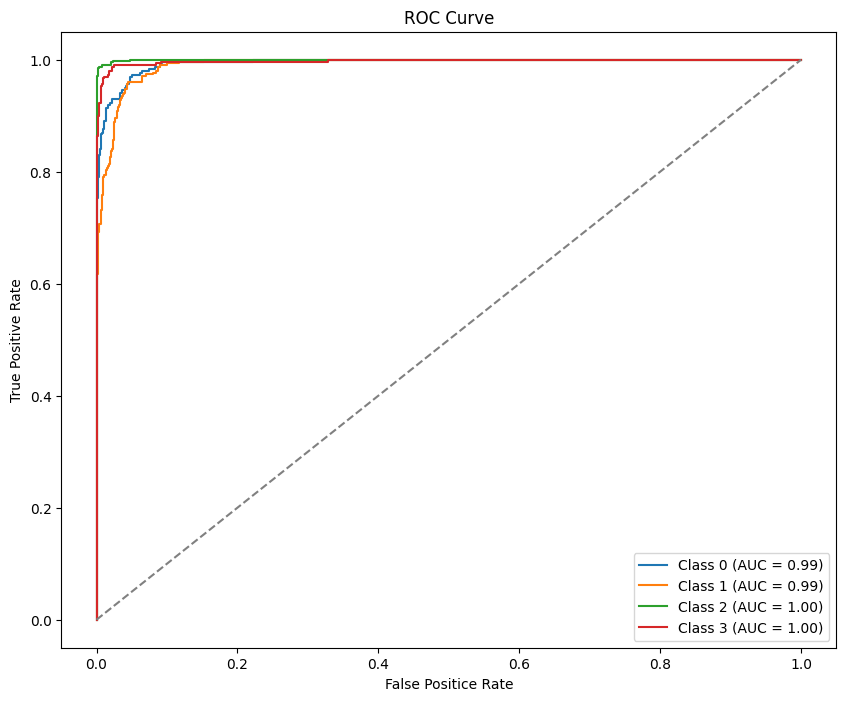

In [28]:
# 4. ROC Curve and AUC 
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
  fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
   plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0,1], [0,1], linestyle='--', color='gray') # Diagonal line

plt.title("ROC Curve")
plt.xlabel("False Positice Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


In [29]:
# Save the entire model
model.save('model.h5')

In [30]:
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('model.h5') 

<>:42: SyntaxWarning: invalid escape sequence '\T'
<>:42: SyntaxWarning: invalid escape sequence '\T'
C:\Users\KIIT\AppData\Local\Temp\ipykernel_55352\1049231033.py:42: SyntaxWarning: invalid escape sequence '\T'
  image_path = '../archive\Training\pituitary\Tr-pi_0133.jpg'  # Note: Using forward slashes


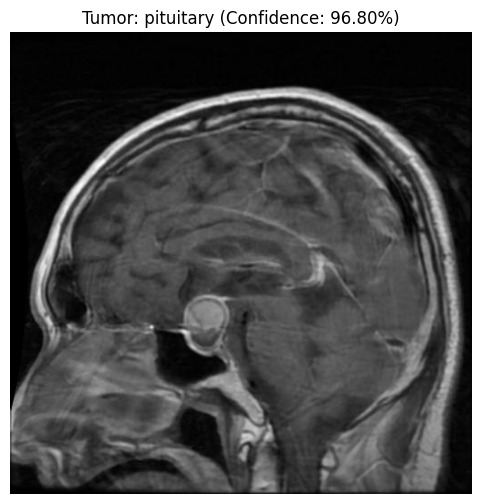

In [40]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import os

class_labels = sorted(os.listdir(train_dir))

def detect_and_display(image_path, model):
    try:
        # Load and preprocess image exactly as in training
        img = load_img(image_path, target_size=(128, 128))
        img = augment_image(img)  # Use the same augment_image function from training
        
        # Expand dimensions for batch
        img_array = np.expand_dims(img, axis=0)
        
        # Prediction
        predictions = model.predict(img_array, verbose=0)
        predicted_class_index = np.argmax(predictions)
        confidence_score = predictions[0][predicted_class_index]
        
        # Print raw predictions for debugging
        
        
        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"
        
        # Display
        plt.figure(figsize=(8, 6))
        plt.imshow(load_img(image_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()
        
    except Exception as e:
        print("Error processing the image:", str(e))

# Test the function
image_path = '../archive\Training\pituitary\Tr-pi_0133.jpg'  # Note: Using forward slashes
detect_and_display(image_path, model)

In [34]:
import os
import numpy as np
import joblib
import random
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageEnhance
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize


In [35]:
# Directories for training and testing data
train_dir = '../archive/Training'
test_dir = '../archive/Testing'

# Load and shuffle the train data
train_paths, train_labels = [], []
for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)
train_paths, train_labels = shuffle(train_paths, train_labels)

# Load and shuffle test data
test_paths, test_labels = [], []
for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)
test_paths, test_labels = shuffle(test_paths, test_labels)


In [37]:
# Image preprocessing
def open_images(paths):
    images = []
    for path in paths:
        img = load_img(path, target_size=(128, 128))
        img = img_to_array(img) / 255.0
        images.append(img)
    return np.array(images)

# Encode labels
def encode_label(labels):
    unique_labels = sorted(os.listdir(train_dir))
    return np.array([unique_labels.index(label) for label in labels])


In [38]:
# Load image data
X_train, X_test = open_images(train_paths), open_images(test_paths)
y_train, y_test = encode_label(train_labels), encode_label(test_labels)

# Feature extraction using VGG16
base_model = VGG16(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False

X_train_features = base_model.predict(X_train)
X_test_features = base_model.predict(X_test)

X_train_flat = X_train_features.reshape(X_train_features.shape[0], -1)
X_test_flat = X_test_features.reshape(X_test_features.shape[0], -1)

179/179 ━━━━━━━━━━━━━━━━━━━━ 415s 2s/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step


In [39]:
# Train Decision Tree classifier
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train_flat, y_train)
dt_preds = dt_clf.predict(X_test_flat)
print("Decision Tree Accuracy:", accuracy_score(y_test, dt_preds))
print(classification_report(y_test, dt_preds))

Decision Tree Accuracy: 0.851258581235698
              precision    recall  f1-score   support

           0       0.82      0.73      0.77       300
           1       0.72      0.79      0.75       306
           2       0.94      0.99      0.97       405
           3       0.90      0.85      0.87       300

    accuracy                           0.85      1311
   macro avg       0.85      0.84      0.84      1311
weighted avg       0.85      0.85      0.85      1311



In [40]:
joblib.dump(dt_clf, "decision_tree.pkl")


['decision_tree.pkl']

In [41]:
# Train Random Forest classifier
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_train_flat, y_train)
rf_preds = rf_clf.predict(X_test_flat)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))
print(classification_report(y_test, rf_preds))

Random Forest Accuracy: 0.931350114416476
              precision    recall  f1-score   support

           0       0.96      0.82      0.88       300
           1       0.85      0.90      0.87       306
           2       0.99      1.00      1.00       405
           3       0.92      0.98      0.95       300

    accuracy                           0.93      1311
   macro avg       0.93      0.93      0.93      1311
weighted avg       0.93      0.93      0.93      1311



In [42]:
joblib.dump(rf_clf, "random_forest.pkl")

['random_forest.pkl']

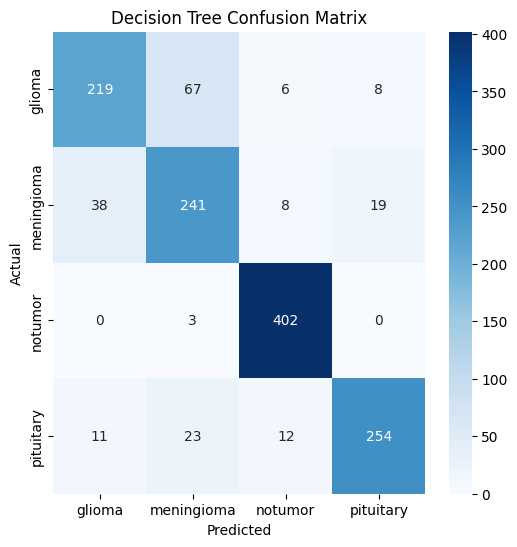

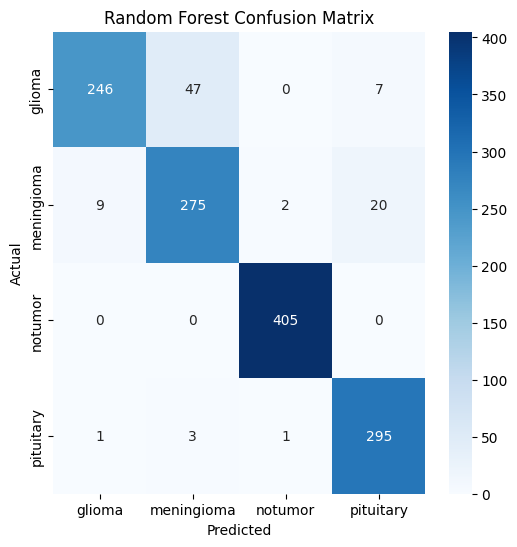

In [ ]:
# Confusion Matrices
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_test, dt_preds, "Decision Tree Confusion Matrix")
plot_confusion_matrix(y_test, rf_preds, "Random Forest Confusion Matrix")

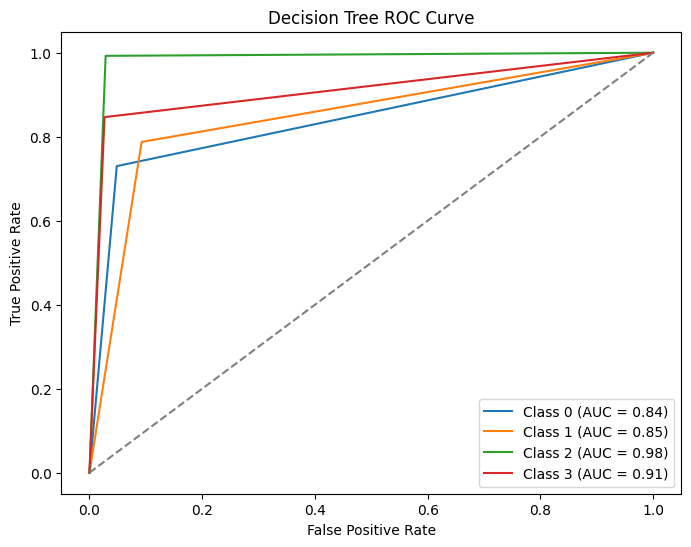

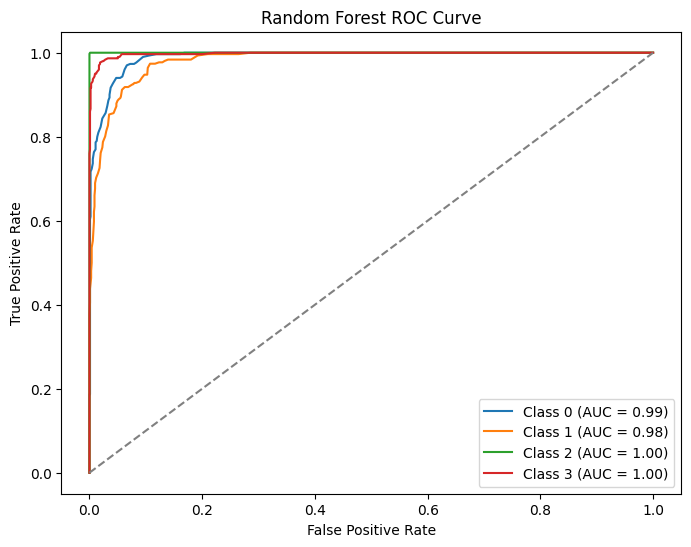

In [25]:
# ROC Curves
def plot_roc_curve(y_true, y_scores, title):
    y_true_bin = label_binarize(y_true, classes=np.arange(len(os.listdir(train_dir))))
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(y_true_bin.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    plt.figure(figsize=(8, 6))
    for i in range(y_true_bin.shape[1]):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.show()

rf_probs = rf_clf.predict_proba(X_test_flat)
dt_probs = dt_clf.predict_proba(X_test_flat)
plot_roc_curve(y_test, dt_probs, "Decision Tree ROC Curve")
plot_roc_curve(y_test, rf_probs, "Random Forest ROC Curve")


In [26]:
# Train deep learning model
model = Sequential([
    Input(shape=(128, 128, 3)),
    base_model,
    Flatten(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(len(os.listdir(train_dir)), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, batch_size=20, validation_data=(X_test, y_test))


Epoch 1/5
286/286 ━━━━━━━━━━━━━━━━━━━━ 521s 2s/step - accuracy: 0.6312 - loss: 0.8792 - val_accuracy: 0.7941 - val_loss: 0.4927
Epoch 2/5
286/286 ━━━━━━━━━━━━━━━━━━━━ 528s 2s/step - accuracy: 0.8453 - loss: 0.4075 - val_accuracy: 0.8665 - val_loss: 0.3564
Epoch 3/5
286/286 ━━━━━━━━━━━━━━━━━━━━ 525s 2s/step - accuracy: 0.8758 - loss: 0.3223 - val_accuracy: 0.8764 - val_loss: 0.3213
Epoch 4/5
286/286 ━━━━━━━━━━━━━━━━━━━━ 526s 2s/step - accuracy: 0.8957 - loss: 0.2858 - val_accuracy: 0.8841 - val_loss: 0.2863
Epoch 5/5
286/286 ━━━━━━━━━━━━━━━━━━━━ 538s 2s/step - accuracy: 0.9074 - loss: 0.2553 - val_accuracy: 0.9031 - val_loss: 0.2632
